In [1]:
import numpy as np
import scipy
import numpy 
import matplotlib.pyplot as plt
from scipy import linalg, special, stats
from numpy import genfromtxt
import ML_support as ml
from scipy.optimize import fmin_l_bfgs_b

In [2]:
def logreg_obj_wrap(DTR, LTR, l):

    def logreg_obj(v):
        n = DTR.shape[1]
        w, b = v[0:-1], v[-1]
        w = w.reshape((len(w), 1))
        J = 0
        x = DTR
        for idx in range(n):
            if LTR[idx] == 0:
                c = 0
            else:
                c = 1

            J += (c * numpy.log1p(numpy.exp(numpy.dot(-w.T, x[:, idx]) - b)) + (1 - c) * numpy.log1p(numpy.exp(numpy.dot(w.T, x[:, idx]) + b)))

        return l/2 * ((numpy.linalg.norm(w))**2) + 1/n * J

    return logreg_obj

In [10]:
def logreg(DTR, LTR, DTE, LTE, l):
    logreg_obj = logreg_obj_wrap(DTR, LTR, l)
    v = numpy.zeros((DTR.shape[0]+1), dtype='int32')
    x, f, d = fmin_l_bfgs_b(logreg_obj, v, approx_grad=True)
    w, b = x[0:-1], x[-1]
    
    w = ml.mcol(w)
    S = numpy.zeros((DTE.shape[1]))
    for i in range(len(S)):
        S[i] = numpy.dot(w.T, DTE[:, i]) + b

    PL = numpy.zeros((len(LTE)))

    for i in range(len(S)):
        if(S[i] > 0):
            PL[i] = 1

    PL = PL == LTE
    correctPred = sum(PL)

    e = (len(LTE)-correctPred)/len(LTE)
    print(f'| lambda = {l} |{logreg_obj(x)}|   {round(e*100, 1)}%     |\n')
        

In [4]:
Data, label = ml.loadFile('../Train.txt')
(DTR, LTR), (DTE,LTE) = ml.split_db_2to1(Data, label, seed=42)
DTR_g, DTE_g = ml.gaussianize(DTR), ml.gaussianize(DTE)
DTR_z, DTE_z = ml.z_normalization(DTR), ml.z_normalization(DTE)


In [5]:
logreg(DTR_g, LTR, DTE_g, LTE, 0)

| l = 0 |[0.08436835]|   2.4%     |



In [6]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.1)

| l = 0.1 |[0.16196515]|   4.3%     |



In [7]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.01)

| l = 0.01 |[0.1075801]|   2.9%     |



In [8]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.001)

| l = 0.001 |[0.09114929]|   2.5%     |



In [9]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.00001)

| l = 1e-05 |[0.08455873]|   2.4%     |



In [11]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.00000001)

| lambda = 1e-08 |[0.08436856]|   2.4%     |



In [14]:
logreg(DTR_z, LTR, DTE_z, LTE, 0)

| lambda = 0 |[0.07299565]|   2.2%     |



In [15]:
logreg(DTR_z, LTR, DTE_z, LTE, 0.1)
logreg(DTR_z, LTR, DTE_z, LTE, 0.01)
logreg(DTR_z, LTR, DTE_z, LTE, 0.001)
logreg(DTR_z, LTR, DTE_z, LTE, 0.00001)

| lambda = 0.1 |[0.14874581]|   4.1%     |

| lambda = 0.01 |[0.10062142]|   2.9%     |

| lambda = 0.001 |[0.08311847]|   2.5%     |

| lambda = 1e-05 |[0.07334328]|   2.2%     |



In [16]:
logreg(DTR_z, LTR, DTE_z, LTE, 0.0000001)

| lambda = 1e-07 |[0.07299922]|   2.2%     |



In [5]:
def logreg_mod1(DTR, LTR, DTE, LTE, l, app, ROC=False):
    logreg_obj = logreg_obj_wrap(DTR, LTR, l)
    v = numpy.zeros((DTR.shape[0]+1), dtype='int32')
    x, f, d = fmin_l_bfgs_b(logreg_obj, v, approx_grad=True)
    w, b = x[0:-1], x[-1]
    
    w = ml.mcol(w)
    S = numpy.zeros((DTE.shape[1]))
    for i in range(len(S)):
        S[i] = numpy.dot(w.T, DTE[:, i]) + b

    CM = ml.compute_optimal_B_decision(app, S, LTE)

    app_bayes_risk=ml.compute_Bayes_risk(CM, app)
    DCF = ml.compute_norm_Bayes(app_bayes_risk, app)

    minDCF= ml.compute_min_DCF(S, app, LTE)
    error = 1-(CM[0, 0]+CM[1,1])/(len(LTE))
    if(ROC == True):
        ml.plot_ROC(app, S, LTE)

    print("\-/ \-/ \-/ \-/ \-/ ")
    print("Logistic Regression error:", error)
    print(app,"DCF:", DCF, "minDCF:", minDCF)
    print('CM\n', CM)
    print("/-\ /-\ /-\ /-\ /-\ ")


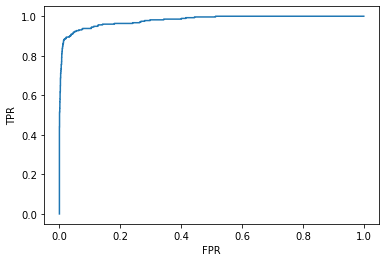

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.023513604299630453
[0.5, 1, 1] DCF: 0.16308996702779088 minDCF: 0.1262620281273131
CM
 [[2674.   42.]
 [  28.  233.]]
/-\ /-\ /-\ /-\ /-\ 


In [6]:
logreg_mod1(DTR_g, LTR, DTE_g, LTE, 0, [1/2, 1,1], True)

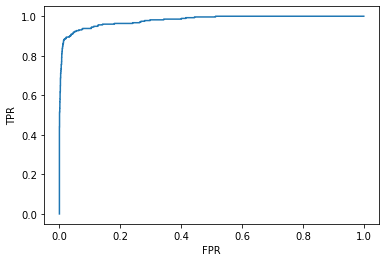

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.028552233792408455
[0.7, 1, 1] DCF: 0.2830154991813022 minDCF: 0.22048224659623622
CM
 [[2648.   31.]
 [  54.  244.]]
/-\ /-\ /-\ /-\ /-\ 


In [7]:
logreg_mod1(DTR_g, LTR, DTE_g, LTE, 0, [0.7, 1,1], True)

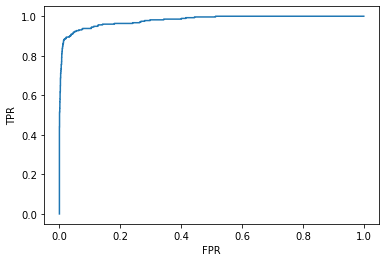

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.06785354383607656
[0.5, 10, 1] DCF: 0.7586367000874773 minDCF: 0.4797456429580782
CM
 [[2519.   19.]
 [ 183.  256.]]
/-\ /-\ /-\ /-\ /-\ 


In [8]:
logreg_mod1(DTR_g, LTR, DTE_g, LTE, 0, [0.5, 10,1], True)

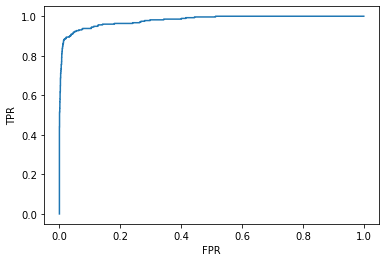

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.055424924420557575
[0.6, 5, 1] DCF: 0.6260211291299375 minDCF: 0.43429109750353273
CM
 [[2558.   21.]
 [ 144.  254.]]
/-\ /-\ /-\ /-\ /-\ 


In [10]:
logreg_mod1(DTR_g, LTR, DTE_g, LTE, 0, [0.6, 5,1], True)

In [11]:
logreg_mod1(DTR_g, LTR, DTE_g, LTE, 0, [0.9, 2,1], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.09439032583137386
[0.9, 2, 1] DCF: 1.2104326761321582 minDCF: 0.5091999192517327
CM
 [[2438.   17.]
 [ 264.  258.]]
/-\ /-\ /-\ /-\ /-\ 


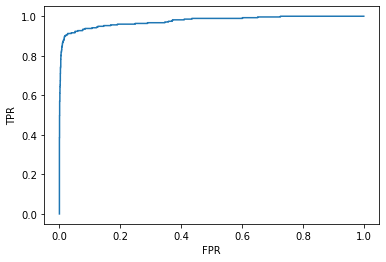

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.022505878401074875
[0.7, 1, 1] DCF: 0.3575012897292689 minDCF: 0.2286243635466433
CM
 [[2676.   41.]
 [  26.  234.]]
/-\ /-\ /-\ /-\ /-\ 


In [12]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.7, 1,1], True)

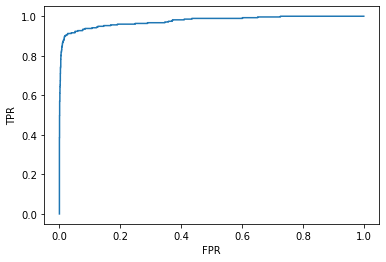

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.022169969768223052
[0.5, 1, 1] DCF: 0.1877397214184779 minDCF: 0.11428975169907812
CM
 [[2686.   50.]
 [  16.  225.]]
/-\ /-\ /-\ /-\ /-\ 


In [13]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.5, 1,1], True)

In [15]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.5, 10,1], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.03527040644944579
[0.5, 10, 1] DCF: 0.9027050669537717 minDCF: 0.5443240697126708
CM
 [[2621.   24.]
 [  81.  251.]]
/-\ /-\ /-\ /-\ /-\ 


In [16]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.5, 1,10], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.03157541148807519
[0.5, 1, 10] DCF: 0.34233497072875313 minDCF: 0.23408384361752238
CM
 [[2694.   86.]
 [   8.  189.]]
/-\ /-\ /-\ /-\ /-\ 


In [17]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.1, 1,1], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.029559959690964033
[0.1, 1, 1] DCF: 0.31755601911042325 minDCF: 0.2244788372249512
CM
 [[2694.   80.]
 [   8.  195.]]
/-\ /-\ /-\ /-\ /-\ 


In [18]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.9, 1,1], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.03258313738663088
[0.9, 1, 1] DCF: 0.8124715698808965 minDCF: 0.5334149788035798
CM
 [[2629.   24.]
 [  73.  251.]]
/-\ /-\ /-\ /-\ /-\ 


In [19]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.8, 3,1], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.04030903594222368
[0.8, 3, 1] DCF: 1.0828019648745042 minDCF: 0.5661422515308525
CM
 [[2606.   24.]
 [  96.  251.]]
/-\ /-\ /-\ /-\ /-\ 


In [20]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.8,1,1], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.023513604299630453
[0.8, 1, 1] DCF: 0.5078689186461209 minDCF: 0.3302092725926923
CM
 [[2666.   34.]
 [  36.  241.]]
/-\ /-\ /-\ /-\ /-\ 


In [21]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.8,1,3], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.022169969768223052
[0.8, 1, 3] DCF: 0.23043222753067316 minDCF: 0.14338066078998724
CM
 [[2682.   46.]
 [  20.  229.]]
/-\ /-\ /-\ /-\ /-\ 
